# Third exercise: k-means (++), k-medoids, c-means
Data source: dataset s3 from http://cs.uef.fi/sipu/datasets/

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
import seaborn as sns
import random

## 1. K-means

1. Program from scratch the clustering algorithm k-means with random initialization.

In [2]:
# compute pair-wise euclidean distance
def sq_euclidean_distance(x, y):
    return np.sum((x-y)**2, axis=-1)

# compute distance between points and cluster centroids
def centroid_distance(X, C):
    return sq_euclidean_distance(X[:, np.newaxis, :], C[np.newaxis, :, :])
    
# assign point to the same cluster of the nearest cluster centroid
def assign(D):
    return np.argsort(D)[:, 0]  # z

# update cluster centroids
def update_centroids(X, z):
    # divide points into clusters
    partition = [X[np.where(z==i), :].squeeze(0) for i in np.unique(z)]
    # average position of points belonging to the cluster
    C = np.array([np.mean(i, axis=0) for i in partition])
    return C

# evaluate objective function: within clusters sums of squares
def objective_f(X, C, z):
    # divide points into clusters
    partition = [X[np.where(z==i), :].squeeze(0) for i in np.unique(z)]
    sum_intra_c = [(sq_euclidean_distance(partition[i][:, np.newaxis, :], 
                    C[np.newaxis, i, :]).sum()) for i in range(len(C))]
    return sum(sum_intra_c)

def k_means_iter(X, z, update_fn):
    C = update_fn(X, z)
    D = centroid_distance(X, C)
    z = assign(D)
    return C, D, z

def k_means(X, C_init, update_fn, k=15):
    D = centroid_distance(X, C_init)
    z_prev = assign(D)
    C, D, z = k_means_iter(X, z_prev, update_fn)
    while (not np.array_equal(z, z_prev)):
        z_prev = z
        C, D, z = k_means_iter(X, z_prev, update_fn)
    obj = objective_f(X, C, z)
    return obj, z, C

def k_means_repeated(X, init_fn, update_fn, k=15, repeats=100):
    obj = []
    min_obj = None
    best_assignation = None
    best_centers = None
    for i in range(repeats):
        C_init = init_fn(X, k)
        obj_i, z, C = k_means(X, C_init, update_fn, k)
        obj.append(obj_i)
        if i==0 or obj_i < min_obj:
            min_obj = obj_i
            best_assignation = z
            best_centers = C
    obj = np.array(obj)
    return np.mean(obj), min_obj, best_assignation, best_centers

2. Load the dataset.

In [3]:
# reading the data
X = np.loadtxt('data/s3.txt', dtype=float)
print("Dimension of the dataset: ", X.shape)
# normalize data
X = np.divide((X - X.mean(axis=0)), X.std(axis=0))

Dimension of the dataset:  (5000, 2)


3. Apply the algorithm with k=15 for 100 times, obtain the best value of the objective function and the average one. Plot the assignation for the best case.

In [4]:
def plot_assignation(X, z, C):
    plt.figure(figsize=(15,10))
    plt.scatter(X[:, 0], X[:, 1], c=z)
    plt.scatter(C[:, 0], C[:, 1], c='red', marker='x')
    plt.show()

In [5]:
# random initialization
def random_init(X, k=15):
    init_idx = np.random.choice(X.shape[0], k, replace=False)
    C_init = X[init_idx, :]
    return C_init

mean_obj, min_obj, z, C = k_means_repeated(X, random_init, update_centroids)
print("Average value of the objective function: ", mean_obj)
print("Best value of the objective function: ", min_obj)

Average value of the objective function:  499.8865389617325
Best value of the objective function:  431.9894665609867


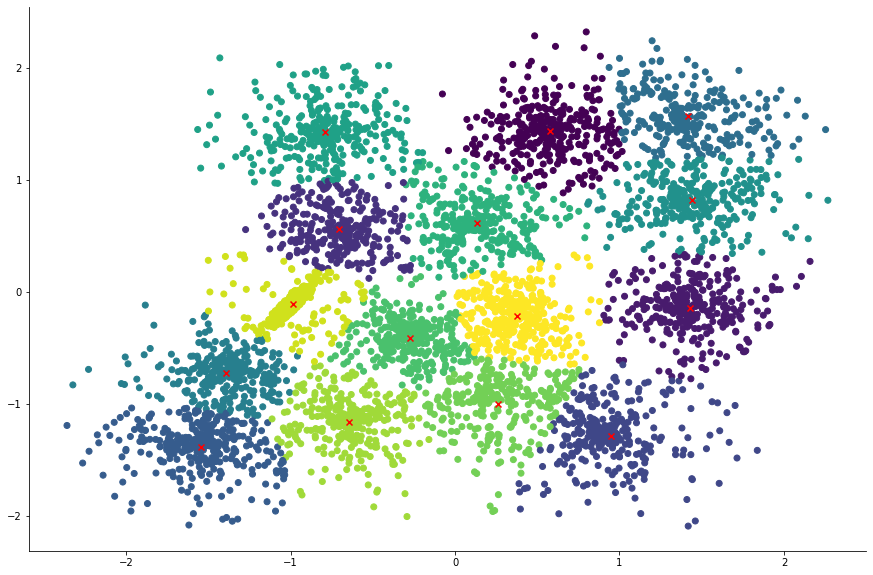

In [6]:
plot_assignation(X, z, C)

4. Implement k-means++ initialization in your algorithm and redo point 3.

In [7]:
def k_plus_plus(X, k=15):
    init_idx = np.random.randint(X.shape[0])
    C = np.array([X[init_idx, :]])
    for i in range(1, k):
        # distance of every point from already computed centroids
        D = centroid_distance(X, C)
        # min distance of every point from centroids
        d = np.min(D, axis=1)
        # prob of points being next centroid
        p = (d**2)/np.sum(d**2)
        # cumulative probability distribution
        cumulative_p = np.cumsum(p)
        r = random.random()
        for j, p in enumerate(cumulative_p):
            if r < p:
                l = j
                break
        C = np.append(C, np.array([X[l, :]]), axis=0)
    return C

In [8]:
mean_obj, min_obj, z, C = k_means_repeated(X, k_plus_plus, update_centroids)
print("Average value of the objective function: ", mean_obj)
print("Best value of the objective function: ", min_obj)

Average value of the objective function:  488.8208843700605
Best value of the objective function:  431.98946656098684


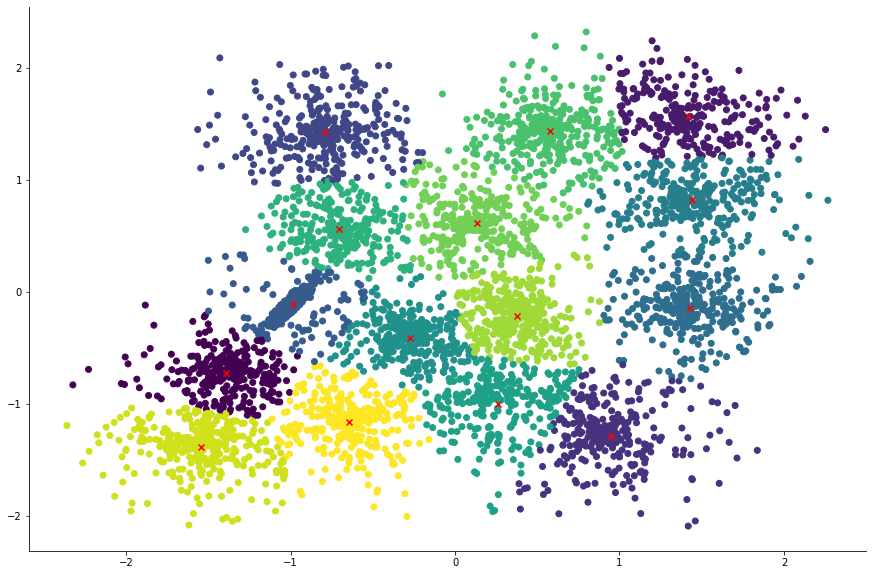

In [9]:
plot_assignation(X, z, C)

5. Perform the scree plot (with k from 2 to 20) for this data set using the best value of the objective function.

In [10]:
def scree_plot(values, min_k, max_k):
    ticks = np.arange(min_k, max_k+1)
    plt.figure(figsize=(16,9))
    plt.scatter(np.arange(len(ticks)), values, marker='o', color='orange')
    plt.xticks(ticks=np.arange(len(ticks)), labels=ticks);
    plt.ylabel("Best value of the objective function")
    plt.xlabel("Number of clusters k")
    plt.show()

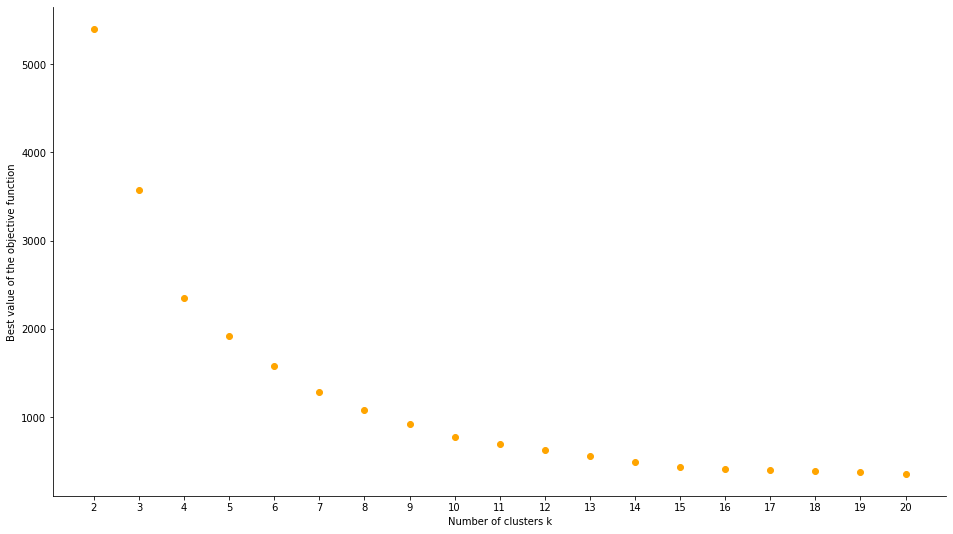

In [11]:
mins = []
for k in range(2, 21):
    _, min_obj, _, _ = k_means_repeated(X, k_plus_plus, update_centroids, k=k)
    mins.append(min_obj)
    
scree_plot(mins, 2, 20)

6. Modify k-means code for obtaining k-medoids.

In [12]:
def update_medoids(X, z):
    # divide points into clusters
    partition = [X[np.where(z==i), :].squeeze(0) for i in np.unique(z)]
    # compute intra-cluster distances
    distances = [sq_euclidean_distance(i[:, np.newaxis, :], i[np.newaxis, :, :]) 
                 for i in partition]
    # sum of distances among cluster members
    sum_distances = [np.sum(d, axis=1) for d in distances]
    min_distances = [np.argmin(s) for s in sum_distances]
    # medoids
    M = np.array([partition[i][j] for i, j in enumerate(min_distances)])
    return M

In [13]:
mean_obj, min_obj, z, C = k_means_repeated(X, random_init, update_medoids, repeats=50)
print("Average value of the objective function: ", mean_obj)
print("Best value of the objective function: ", min_obj)

Average value of the objective function:  533.474563357971
Best value of the objective function:  478.9121978067892


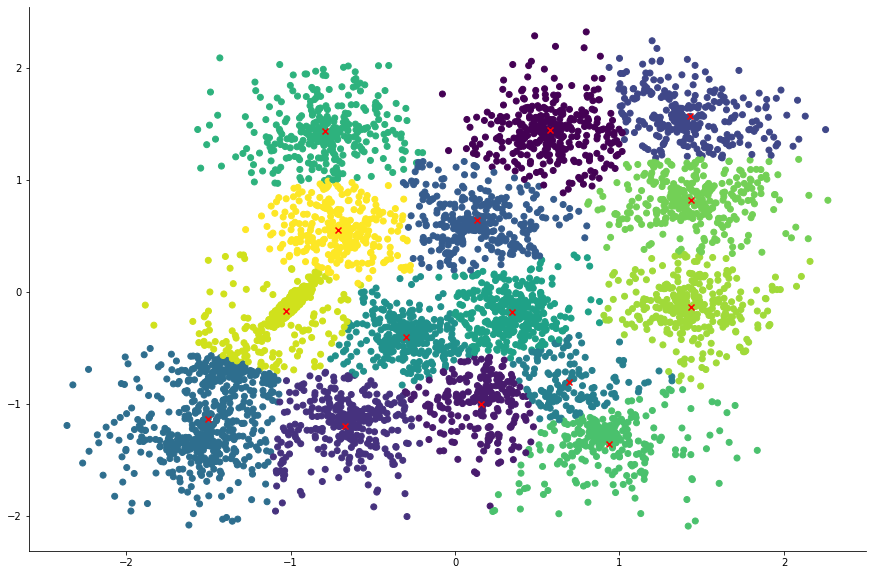

In [14]:
plot_assignation(X, z, C)

## 2. Fuzzy c-means

1. Modify k-means for obtaining c-means.

In [15]:
# randomly initialize membership matrix
def U_init(N, k):
    U = np.random.rand(N, k)
    U = np.divide(U, (np.sum(U, axis=1)[:, None]))
    return U

# compute cluster centers
def compute_centers(U, X, k, m=2):
    U_m = U**m
    U_m_col_sums = np.sum(U_m, axis=0)  # denominator
    # average value of cluster coordinates
    C = np.array([np.sum(np.multiply(X, U_m[:, i, np.newaxis]), axis=0) 
                  for i in range(U_m.shape[1])])  # numerator
    C = np.divide(C, U_m_col_sums[:, np.newaxis])
    assert (C.shape == (k, X.shape[1]))
    return C

# update U
def U_update(X, C, k, m=2):
    D = centroid_distance(X, C)
    # for every point, ratio between distance from current center and all the centers
    y = [np.array([np.divide(D[i, j], D[i, :]) 
         for j in range(D.shape[1])]) for i in range(D.shape[0])]
    # new membership matrix
    U = np.array([1/np.sum(j**(2/(m-1)), axis=1) for j in y])
    assert (U.shape == (X.shape[0], k))
    return U

# objective function 
def objective_f(X, U, k, m=2):
    D = centroid_distance(X, C)
    U_m = U**m
    obj = np.sum(np.array([np.sum(np.multiply(D, U_m[:, i, np.newaxis])) 
                 for i in range(U_m.shape[1])]))
    return obj


def fuzzy_c_means(X, k, max_iters=100, m=2):
    U = U_init(X.shape[0], k)
    for i in range(max_iters):
        C = compute_centers(U, X, k, m)
        U = U_update(X, C, k, m)
    obj = objective_f(X, U, k, m)
    return obj, C, U


def fuzzy_c_means_repeated(X, k, repeats=20, max_iters=100, m=2):
    objs = []
    min_obj = None
    best_U = None
    best_C = None
    for i in range(repeats):
        obj_i, C, U = fuzzy_c_means(X, k, max_iters, m)
        if i==0 or obj_i < min_obj:
            min_obj = obj_i
            best_U = U
            best_C = C
        objs.append(obj_i)
    objs = np.array(objs)
    return np.mean(objs), min_obj, best_U, best_C

2. Perform the scree plot for the same data set.

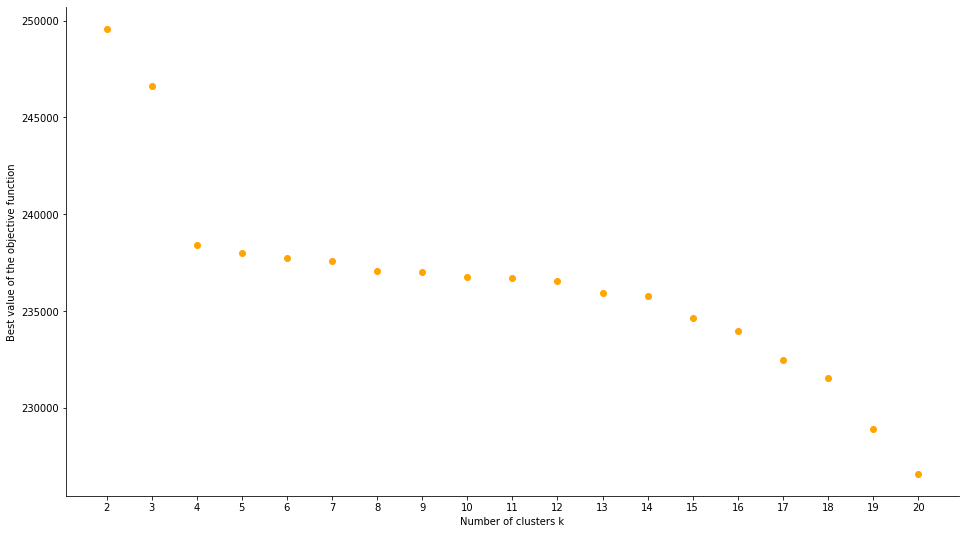

In [22]:
mins = []
for k in range(2, 21):
    _, min_obj, _, _ = fuzzy_c_means_repeated(X, k=k)
    mins.append(min_obj)

scree_plot(mins, 2, 20)

3. Plot the assignation for the best case.

In [23]:
mean_obj, min_obj, U, C = fuzzy_c_means_repeated(X, k=20)
print("Average value of the objective function: ", mean_obj)
print("Best value of the objective function: ", min_obj)

Average value of the objective function:  316047.165337619
Best value of the objective function:  313175.4797820012


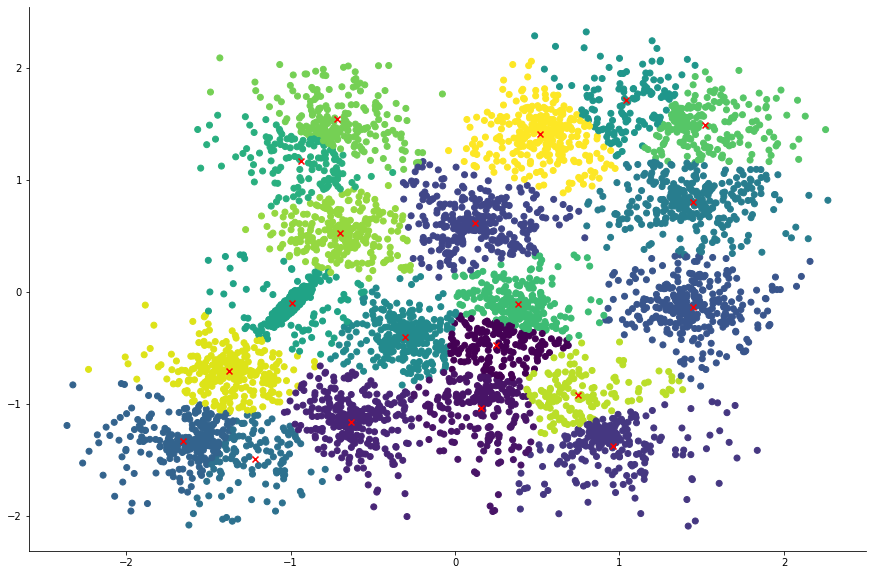

In [24]:
plot_assignation(X, np.argmax(U, axis=1), C)